# TDE Timeline Plots

This jupyter notebook contains python code for the production of:
- TDE timeline plots

This module takes in:

1) 'TDE Observations' folder with individual TDE observation folders that contain observational TDE observation '.txt' files from XMM Newton, Chandra, and Swift space observatories obtained from the NASA HEASARC database (https://heasarc.gsfc.nasa.gov)

and generates timeline plots of each observation made on each TDE Target.

The output file is 'TDE Timeline Plots.pdf'

## Outline of Code
### Reading and parsing files
Define a function to to read a file and extract info into form [tde name, telescope, dates, delta dates].

Define another function to use func above to iterate through all files and save into form [[date set 1], [data set 2], ...].
### Graphing
Assign each data set in func above a y value = [0,0,0, ...], [-1,-1,-1, ...], etc. to create a stacked timeline of the data.




In [1]:
# Toggle file saving
# file_save = True
file_save = False

In [2]:
def tde_date_list_func(file_name_with_directory):
    import datetime as dt
    import csv

    tde_dates = []
    tde_dates_str = []
#     print("(print id 1)",file_name_with_directory)
    file_name = file_name_with_directory.split('/')[2]
    print(file_name)
#     print("(print id 2)",file_name_with_directory)
    file_tde_date = dt.date(int(file_name.split('_')[3])
                            ,int(file_name.split('_')[4])
                            ,int(file_name.split('_')[5].split('.')[0])
                           )

    # Open and read/copy file for use
#     print("opening: ", file_name_with_directory)
    with open(file_name_with_directory,'r') as f:
        full_read_data = f.readlines()

    reduced_read_data = []

    for line_num, line in enumerate(full_read_data):
        if line == "\n":  # stops after main body
            break
        if line_num > 0:  # skips header
            reduced_read_data.append(line)

    # for looping over more than one file
    #if reduced_read_data == []:
    #    continue  # skips empty file and moves to next file in folder

    # Grab header and strip excess whitespace and characters
    stripped_header = [header.strip().strip('_') for header in full_read_data[0].split('|')]

    read_data_dictionary = csv.DictReader(reduced_read_data, fieldnames=stripped_header, delimiter='|')

    # Determine file source name for appropriate data reader
#     print("determining xmm or swift or chandra:", file_name_with_directory.lower().split('/')[6].split('_')[1:])
    if "xmm" in file_name_with_directory.lower().split('/')[2].split('_')[1:]:
        file_telescope_source_name = "xmm"
    elif "chandra" in file_name_with_directory.lower().split('/')[2].split('_')[1:]:
        file_telescope_source_name = "chandra"
    elif "swift" in file_name_with_directory.lower().split('/')[2].split('_')[1:]:
        file_telescope_source_name = "swift"
    else:  # unknown file type, end program
        print(f"{file_name_with_directory} Data type unknown. Program terminated.")
        quit()
        
    for line_index, observation in enumerate(read_data_dictionary):  # Runs file copy line by line

        # format
        # xmm: ['obsid', 'status', 'name', 'ra', 'dec', 'time', 'duration', 'pi_lname', 'pi_fname', 'public_date', 'data_in_heasarc', 'offset']
        # swift: ['name', 'obsid', 'ra', 'dec', 'start_time', 'processing_date', 'xrt_exposure', 'uvot_exposure', 'bat_exposure', 'archive_date', 'offset']
        # chandra: ['obsid', 'status', 'name', 'ra', 'dec', 'time', 'detector', 'grating', 'exposure', 'type', 'pi', 'public_date', 'offset']

        observation_id = observation['obsid']
        offset = float(observation['offset'])
        if file_telescope_source_name == "swift":
            observation_date = observation['start_time'].split('T')[0].strip()
    #         xrt_exposure_time = float(observation['xrt_exposure'])
    #         uv_exposure_time = float(observation['uvot_exposure'])
        else:
            observation_date = observation['time'].split('T')[0].strip()
    #     if file_telescope_source_name == "xmm":
    #         xrt_exposure_time = float(observation['duration'])
    #     if file_telescope_source_name == "chandra":
    #         xrt_exposure_time = float(observation['exposure'])

    #     if file_telescope_source_name == "chandra":  # for chandra data
    #         detector = observation['detector']
    #         output_obsid_date_exp_time += f"{observation_id} ({observation_date}, {xrt_exposure_time}, {detector}), "
    #     else:
    #         output_obsid_date_exp_time += f"{observation_id} ({observation_date}, {xrt_exposure_time}), "

        # get year, month, day info
        if observation_date.strip() == "null":  # For rare cases where date is missing in file
            print("date == null")
            skip_input = input("verify skip y/n? (y: skips, n: ends program) : ")
            if skip_input == "y":
                continue

        observation_date_components = observation_date.split('-')

        observation_year, observation_month, observation_day = int(observation_date_components[0]), int(observation_date_components[1]), int(observation_date_components[2])
        observation_date = dt.date(observation_year, observation_month, observation_day)

        delta_date = observation_date - file_tde_date  # difference between epoch and discovery dates
        delta_date = delta_date.days  # output from "# days, XX:XX:XX" to "#" of days

        ### NEW
        if delta_date == 1:  # (e.g. dt=1) Make sure 1 dt's can be distinguished from 0 dt's
            delta_date = 1.5  # (e.g dt=1.5 now)
            
        if delta_date == 0:  # (e.g. dt=0) Make sure 0 dt's can be graphed in log plots
            delta_date = 1  # (e.g. dt=1 now)
        ###
        
        ### REDONE (excludes dt's < 0)
        if delta_date >= 0:
            tde_dates.append(delta_date)
            tde_dates_str.append(observation_date.isoformat())
        ###
        
    return file_telescope_source_name, tde_dates, tde_dates_str

# Function to read in folders
def read_folders_in(os_directory):
    import os

    folders = [folder for folder in os.listdir(os_directory)]

    tde_folders = []

    for folder in folders:  # Filters out mac default folder
        if not folder == ".DS_Store":
            tde_folders.append(folder)

    tde_folders.sort(key=str.lower)  # alphabetizes list, key ensures that lowercase names are accounted for (otherwise they get added last)

    return tde_folders


# Start of iteration function
def master_func(base_directory, master_folder):
    import os
    
    master_list = [] # initialize master list to collect file info

    tde_master_folder = master_folder
    # print(tde_master_folder)
    
    while '.ipynb_checkpoints' in tde_master_folder:  # remove instances of irrelevant folders
        tde_master_folder.remove('.ipynb_checkpoints')
    # print(tde_master_folder)
    
    for m,tde_folder in enumerate(tde_master_folder):  # TDE_folders as returned by read_folder_in() function
        print('\n', m, tde_folder)
        tde_name = tde_folder.split('_')[0]
#             tde_dictionary = {'TDE_Name': TDE_folder.split('_')[0], 'TDE_Date': TDE_folder.split('_')[2:]}
#             # print(tde_dictionary.values())

        tde_folder_directory = f"{base_directory}/{tde_folder}"
#         print(tde_folder_directory)

        raw_tde_files = [folder for folder in os.listdir(tde_folder_directory)]

        tde_files = []

        for file in raw_tde_files:  # Filters out mac default files
            if not file in [".DS_Store", '.ipynb_checkpoints']:
                tde_files.append(file)
    
        for n,file in enumerate(tde_files):
#             # for marker color
#             if n==0: 
#                 marker_color = 'm'
#             if n==1: 
#                 marker_color = 'y'
#             if n==2: 
#                 marker_color = 'c'

            date_list = tde_date_list_func(f"{tde_folder_directory}/{file}")
            
            # for marker color
            if date_list[0]=="xmm": 
                marker_color = 'tab:blue'
            if date_list[0]=="chandra": 
                marker_color = 'tab:orange'
            if date_list[0]=="swift": 
                marker_color = 'tab:green'
            
    
            master_list.append([tde_name, marker_color, m, n, date_list])
    
    return master_list

# print(master_func())


 0 2MASX J01190869-3411305_Data_2010_07_01
2MASX J01190869-3411305_XMM_Data_2010_07_01.txt
2MASX J01190869-3411305_Swift_Data_2010_07_01.txt
2MASX J01190869-3411305_Chandra_Data_2010_07_01.txt

 1 2XMM J123103.2+110648_Data_2003_07_13
2XMM J123103.2+110648_Swift_Data_2003_07_13.txt
2XMM J123103.2+110648_Chandra_Data_2003_07_13.txt
2XMM J123103.2+110648_XMM_Data_2003_07_13.txt

 2 2XMMi J184725.1-631724_Data_2006_09_01
2XMMi J184725.1-631724_XMM_Data_2006_09_01.txt
2XMMi J184725.1-631724_Chandra_Data_2006_09_01.txt
2XMMi J184725.1-631724_Swift_Data_2006_09_01.txt

 3 3XMM J150052.0+015452_Data_2005_07_23
3XMM J150052.0+015452_Chandra_Data_2005_07_23.txt
3XMM J150052.0+015452_Swift_Data_2005_07_23.txt
3XMM J150052.0+015452_XMM_Data_2005_07_23.txt

 4 3XMM J152130.7+074916_Data_2000_08_23
3XMM J152130.7+074916_Chandra_Data_2000_08_23.txt
3XMM J152130.7+074916_Swift_Data_2000_08_23.txt
3XMM J152130.7+074916_XMM_Data_2000_08_23.txt

 5 3XMM J215022.4-055108_Data_2005_05_01
3XMM J215022.4-0

verify skip y/n? (y: skips, n: ends program) :  y


SDSS J232348.61-010810.3_XMM_Data_2007_06_18.txt

 105 UGC 01791_Data_2005_01_09
UGC 01791_Swift_Data_2005_01_09.txt

 106 UGC 03317_Data_2010_09_22

 107 WINGS J134849.88+263557.5_Data_1999_12_20
WINGS J134849.88+263557.5_XMM_Data_1999_12_20.txt
WINGS J134849.88+263557.5_Chandra_Data_1999_12_20.txt
WINGS J134849.88+263557.5_Swift_Data_1999_12_20.txt

 108 XMMSL1 J024916.6-041244_Data_2004_07_24
WISEA J024917.31-041251.9_Swift_Data_2004_07_24.txt
WISEA J024917.31-041251.9_XMM_Data_2004_07_24.txt
WISEA J024917.31-041251.9_Chandra_Data_2004_07_24.txt

 109 XMMSL1 J061927.1-655311_Data_2012_11_12
XMMSL1 J061927.1-655311_XMM_Data_2012_11_12.txt
XMMSL1 J061927.1-655311_Swift_Data_2012_11_12.txt

 110 XMMSL1 J063045.9-603110_Data_2011_12_01
XMMSL1 J063045.9-603110_Swift_Data_2011_12_01.txt
XMMSL1 J063045.9-603110_XMM_Data_2011_12_01.txt

 111 XMMSL1 J0740-85_Data_2014_04_01
2MASX 07400785-8539307_Swift_Data_2014_04_01.txt
2MASX 07400785-8539307_XMM_Data_2014_04_01.txt

 112 XMMSL1 J131952.3+

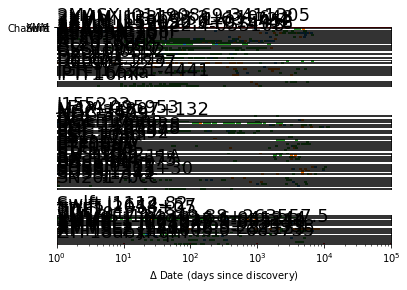

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime

import pandas as pd

master_set = master_func('TDE Observations', read_folders_in('TDE Observations'))
# print(master_set)
master_df = pd.DataFrame(master_set)

# set_size = len(master_set)  # this does not work since len is based on # of sub folders not primary folders
set_size = 116  # need to generalize this
print(set_size)

tde_delta_dates_with_i_value_list = []

for i, data_set in enumerate(master_set):
    tde_name, marker_color, m, n, item_set = data_set
    file_telescope_source_name, tde_delta_dates, tde_date_str = item_set #np.array(data_set)
    
    tde_delta_dates_with_i_value = [tde_name, marker_color, n, m, tde_delta_dates, file_telescope_source_name]
    tde_delta_dates_with_i_value_list.append(tde_delta_dates_with_i_value)
    
"""""""""Plotting"""""""""
fig, axs = plt.subplots(set_size)  # Sets number of subplots

'''''''''Subplotting loop'''''''''
for items in tde_delta_dates_with_i_value_list:
    '''use imported variables from read file'''
    tde_name = items[0]
    marker_color = items[1]
    plot_subindex = items[2]
    plot_index = items[3]
    tde_delta_dates_2 = items[4]
    file_telescope_source_name = items[5]

    
    '''delete unused plots'''
#     if tde_delta_dates_2 == []:
#         delete_indecies
#         continue  # skips empty plots / doesn't work 

    '''Define x,y variables to be plotted'''
    x = [int(date) for date in tde_delta_dates_2]
    
    if file_telescope_source_name=="xmm":
        y=[0]*len(tde_delta_dates_2)
    if file_telescope_source_name=="chandra":
        y=[1]*len(tde_delta_dates_2)
    if file_telescope_source_name=="swift":
        y=[2]*len(tde_delta_dates_2)
#     y = [plot_subindex]*len(tde_delta_dates_2)

    """Set axes"""
#     axs[plot_index].set_xticks([1,10,100,1000,10000], ['$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$'])
    axs[plot_index].set_xscale('log')
    
    axs[plot_index].set_yticks([0,1,2])
#     axs[plot_index].set_yticklabels(['Chandra','Swift','XMM'])  # for all plot
    axs[0].set_yticklabels(['Chandra','Swift','XMM'])  # for first plot
    
    axs[plot_index].set_ylim(-.5,2.5)
    axs[plot_index].set_xlim(1, 100000)
    
    """Plot settings"""
    plt.rcParams['figure.figsize'] = (16,24*8)
    plt.rcParams['xtick.major.width'] = 10
    plt.rcParams['xtick.labelsize'] = 15  # x-axis tick label font size
    plt.rcParams['ytick.labelsize'] = 15  # y axis tick label font size
    plt.rcParams.update({'font.size':15})  # subplot title font size
    axs[plot_index].grid(True)
#     plt.grid(True)
#     if plot_subindex == 0:
#         axs[plot_index].grid()

    """Add Subplot Titles"""
#     axs[0].set_title('Timeline')
    axs[plot_index].set_title(f'{tde_name}',loc='left')
    
    """add axes titles"""
    '''x axis title'''
    axs[-1].set_xlabel('$\Delta$ Date (days since discovery)')  # labels only last plot
#     axs[plot_index].set_xlabel('$\Delta$ Date (days since discovery)')  # labels all plots
    '''y axis title'''
#     axs[plot_index].set_ylabel(f'{tde_name}',rotation=0)

    """remove axes titles"""
    '''x axis removal'''
#     axs[plot_index].axes.get_xaxis().set_visible(False) # removes x-labels for all
    if plot_index < set_size-1: # removes x-labels for all but last row
        axs[plot_index].axes.get_xaxis().set_visible(False)
    '''y axis removal'''
#     axs[plot_index].axes.get_yaxis().set_visible(False) # removes y-labels for all
    if plot_index > 0:  # removes y-labels for all but first rows
        axs[plot_index].axes.get_yaxis().set_visible(False) 
    
    """add subplot labels inside plot area"""
#     fig.text(0, 0.01*plot_index, s=f"{tde_name}", fontsize=15)

    """plotting"""
#     axs[plot_index].plot(x,y,f'{marker_color}|', markersize=20)  # for simple markers
#     axs[plot_index].plot(x,y, color=f'{marker_color}', marker='$|$', markersize=10) # for string markers
    axs[plot_index].scatter(x,y, s=300, color=f'{marker_color}', marker='$|$') # Scatter Plot version, s=size of markers

"""""""""Post-Plotting Adjustments"""""""""
'''Main Title'''
# fig.suptitle('TDE Timelines', va='top', fontsize=20)
# fig.suptitle('TDE Timelines', fontsize=20)  #alt

'''Spacing'''
fig.subplots_adjust(hspace=.7)  # adjusts spacing between plots. hspace in fraction of total subplot height.
# fig.tight_layout()  # too restictive

'''Deleting empty plots'''
kept_indices = []
deleted_indices = []  # to keep track of deleted indices
manual_delete_indicies = [10,set_size-1] # These are outside range of x axis.
deleted_indices = manual_delete_indicies

for i in range(set_size):
#     print(axs[i].get_title(loc='left'))
    axs[i].grid(visible=True, which='major', axis='both', color='r', linestyle='-', linewidth=2)
    if axs[i].get_title(loc='left')=="": 
        print(f"deleting {i}th row")
        fig.delaxes(axs[i])
#         axs[i].set_visible(False)
        deleted_indices.append(i)
    else:
        if i not in manual_delete_indicies:  # to ensure we don't add back the manually deleted items
            kept_indices.append(i)
print(deleted_indices, "\n", kept_indices, len(kept_indices), )

# for j,element in enumerate(kept_indices):
#     axs[element]=axs[j]
        


In [4]:
master_df.head(30)

,0,1,2,3,4
0,2MASX J01190869-3411305,tab:blue,0,0,"(xmm, [154, 1618, 3098, 3121, 3256, 3480, 3619..."
1,2MASX J01190869-3411305,tab:green,0,1,"(swift, [57, 413, 3311, 298, 3228, 381, 354, 3..."
2,2MASX J01190869-3411305,tab:orange,0,2,"(chandra, [3150], [2019-02-14])"
3,2XMM J123103.2+110648,tab:green,1,0,"(swift, [3957, 3952, 3912, 3526, 3631, 3992, 3..."
4,2XMM J123103.2+110648,tab:orange,1,1,"(chandra, [4595], [2016-02-10])"
5,2XMM J123103.2+110648,tab:blue,1,2,"(xmm, [1, 884, 888, 885, 889], [2003-07-13, 20..."
6,2XMMi J184725.1-631724,tab:blue,2,0,"(xmm, [5, 2375, 227], [2006-09-06, 2013-03-03,..."
7,2XMMi J184725.1-631724,tab:orange,2,1,"(chandra, [2401], [2013-03-29])"
8,2XMMi J184725.1-631724,tab:green,2,2,"(swift, [4778, 1636, 3117, 2408, 2564, 2410, 2..."
9,3XMM J150052.0+015452,tab:orange,3,0,"(chandra, [1048, 2085, 2074, 2082, 2084, 2076,..."


# Version 2

The first plot above does not generate a nice-looking plot. The code below uses information about TDEs that do not have data associated with them to delete empty plots in the final output.

In [8]:
def tde_date_list_func(file_name_with_directory):
    import datetime as dt
    import csv

    tde_dates = []
    tde_dates_str = []
#     print("(print id 1)",file_name_with_directory)
    file_name = file_name_with_directory.split('/')[2]
    print(file_name)
#     print("(print id 2)",file_name_with_directory)
    file_tde_date = dt.date(int(file_name.split('_')[3])
                            ,int(file_name.split('_')[4])
                            ,int(file_name.split('_')[5].split('.')[0])
                           )
    
    with open(file_name_with_directory,'r') as f:
        full_read_data = f.readlines()

    reduced_read_data = []

    for line_num, line in enumerate(full_read_data):
        if line == "\n":  # stops after main body
            break
        if line_num > 0:  # skips header
            reduced_read_data.append(line)

    # Grab header and strip excess whitespace and characters
    stripped_header = [header.strip().strip('_') for header in full_read_data[0].split('|')]

    read_data_dictionary = csv.DictReader(reduced_read_data, fieldnames=stripped_header, delimiter='|')

    # Determine file source name for appropriate data reader
    if "xmm" in file_name_with_directory.lower().split('/')[2].split('_')[1:]:
        file_telescope_source_name = "xmm"
    elif "chandra" in file_name_with_directory.lower().split('/')[2].split('_')[1:]:
        file_telescope_source_name = "chandra"
    elif "swift" in file_name_with_directory.lower().split('/')[2].split('_')[1:]:
        file_telescope_source_name = "swift"
    else:  # unknown file type, end program
        print(f"{file_name_with_directory} Data type unknown. Program terminated.")
        quit()
        
    for line_index, observation in enumerate(read_data_dictionary):  # Runs file copy line by line

        # format
        # xmm: ['obsid', 'status', 'name', 'ra', 'dec', 'time', 'duration', 'pi_lname', 'pi_fname', 'public_date', 'data_in_heasarc', 'offset']
        # swift: ['name', 'obsid', 'ra', 'dec', 'start_time', 'processing_date', 'xrt_exposure', 'uvot_exposure', 'bat_exposure', 'archive_date', 'offset']
        # chandra: ['obsid', 'status', 'name', 'ra', 'dec', 'time', 'detector', 'grating', 'exposure', 'type', 'pi', 'public_date', 'offset']

        observation_id = observation['obsid']
        offset = float(observation['offset'])
        if file_telescope_source_name == "swift":
            observation_date = observation['start_time'].split('T')[0].strip()
        else:
            observation_date = observation['time'].split('T')[0].strip()
    
        # get year, month, day info
        if observation_date.strip() == "null":  # For rare cases where date is missing in file
            print("date == null")
            skip_input = input("verify skip y/n? (y: skips, n: ends program) : ")
            if skip_input == "y":
                continue

        observation_date_components = observation_date.split('-')

        observation_year, observation_month, observation_day = int(observation_date_components[0]), int(observation_date_components[1]), int(observation_date_components[2])
        observation_date = dt.date(observation_year, observation_month, observation_day)

        delta_date = observation_date - file_tde_date  # difference between epoch and discovery dates
        delta_date = delta_date.days  # output from "# days, XX:XX:XX" to "#" of days

        ### NEW
        # print(delta_date)
        # if delta_date == 1:  # (e.g. dt=1) Make sure 1 dt's can be distinguished from 0 dt's
        #     print(delta_date)
        #     delta_date = 1.5  # (e.g dt=1.5 now)
        #     print("is now ", delta_date)
            
        # if delta_date == 0:  # (e.g. dt=0) Make sure 0 dt's can be graphed in log plots
        #     print(delta_date)
        #     delta_date = 0.75  # (e.g. dt=0.75 now)
        #     print("is now ", delta_date)
        ###
        
        ### REDONE (excludes dt's < 0)
        if delta_date >= 0:
            tde_dates.append(delta_date)
            tde_dates_str.append(observation_date.isoformat())
        ###
        
    return file_telescope_source_name, tde_dates

# Function to read in folders
def read_folders_in(os_directory):
    import os

    folders = [folder for folder in os.listdir(os_directory)]

    tde_folders = []

    for folder in folders:  # Filters out mac default folder
        if not folder == ".DS_Store":
            tde_folders.append(folder)

    tde_folders.sort(key=str.lower)  # alphabetizes list, key ensures that lowercase names are accounted for (otherwise they get added last)

    return tde_folders


# Start of iteration function
def master_func(base_directory, master_folder):
    import os
    
    master_list = [] # initialize master list to collect file info

    tde_master_folder = master_folder
    
    while '.ipynb_checkpoints' in tde_master_folder:  # remove instances of irrelevant folders
        tde_master_folder.remove('.ipynb_checkpoints')
    # print(tde_master_folder)
    
    for m,tde_folder in enumerate(tde_master_folder):  # TDE_folders as returned by read_folder_in() function
        sub_master_list =[]
        tde_name = tde_folder.split('_')[0]
        tde_folder_directory = f"{base_directory}/{tde_folder}"
        raw_tde_files = [folder for folder in os.listdir(tde_folder_directory)]
        tde_files = []

        for file in raw_tde_files:  # Filters out mac default files
            if not file in [".DS_Store", '.ipynb_checkpoints']:
                tde_files.append(file)
    
        for n,file in enumerate(tde_files):
            date_list = tde_date_list_func(f"{tde_folder_directory}/{file}")
            
            # for marker color
            if date_list[0]=="xmm": 
                marker_color = 'tab:blue'
            if date_list[0]=="chandra": 
                marker_color = 'tab:orange'
            if date_list[0]=="swift": 
                marker_color = 'tab:green'
            
    
            sub_master_list.append([tde_name, marker_color, m, n, date_list])
        master_list.append(sub_master_list)
    
    return master_list

# print(master_func())

### NOTE:
This code below does not always generate a nice-looking plot. Re-run the cell below until it generates a cohesive plot.

2MASX J01190869-3411305_XMM_Data_2010_07_01.txt
2MASX J01190869-3411305_Swift_Data_2010_07_01.txt
2MASX J01190869-3411305_Chandra_Data_2010_07_01.txt
2XMM J123103.2+110648_Swift_Data_2003_07_13.txt
2XMM J123103.2+110648_Chandra_Data_2003_07_13.txt
2XMM J123103.2+110648_XMM_Data_2003_07_13.txt
2XMMi J184725.1-631724_XMM_Data_2006_09_01.txt
2XMMi J184725.1-631724_Chandra_Data_2006_09_01.txt
2XMMi J184725.1-631724_Swift_Data_2006_09_01.txt
3XMM J150052.0+015452_Chandra_Data_2005_07_23.txt
3XMM J150052.0+015452_Swift_Data_2005_07_23.txt
3XMM J150052.0+015452_XMM_Data_2005_07_23.txt
3XMM J152130.7+074916_Chandra_Data_2000_08_23.txt
3XMM J152130.7+074916_Swift_Data_2000_08_23.txt
3XMM J152130.7+074916_XMM_Data_2000_08_23.txt
3XMM J215022.4-055108_XMM_Data_2005_05_01.txt
3XMM J215022.4-055108_Chandra_Data_2005_05_01.txt
3XMM J215022.4-055108_Swift_Data_2005_05_01.txt
ASASSN-14ae_Swift_Data_2014_01_25.txt
ASASSN-14ae_Chandra_Data_2014_01_25.txt
ASASSN-14ae_XMM_Data_2014_01_25.txt
ASASSN-14li_C

verify skip y/n? (y: skips, n: ends program) :  y


SDSS J232348.61-010810.3_XMM_Data_2007_06_18.txt
UGC 01791_Swift_Data_2005_01_09.txt
WINGS J134849.88+263557.5_XMM_Data_1999_12_20.txt
WINGS J134849.88+263557.5_Chandra_Data_1999_12_20.txt
WINGS J134849.88+263557.5_Swift_Data_1999_12_20.txt
WISEA J024917.31-041251.9_Swift_Data_2004_07_24.txt
WISEA J024917.31-041251.9_XMM_Data_2004_07_24.txt
WISEA J024917.31-041251.9_Chandra_Data_2004_07_24.txt
XMMSL1 J061927.1-655311_XMM_Data_2012_11_12.txt
XMMSL1 J061927.1-655311_Swift_Data_2012_11_12.txt
XMMSL1 J063045.9-603110_Swift_Data_2011_12_01.txt
XMMSL1 J063045.9-603110_XMM_Data_2011_12_01.txt
2MASX 07400785-8539307_Swift_Data_2014_04_01.txt
2MASX 07400785-8539307_XMM_Data_2014_04_01.txt
XMMSL1 J131952.3+225958_XMM_Data_2005_07_15.txt
XMMSL1 J131952.3+225958_Swift_Data_2005_07_15.txt
XMMSL2 J140446.9-251135_Swift_Data_2018_02_15.txt
XMMSL2 J140446.9-251135_XMM_Data_2018_02_15.txt
XMMSL2 J144605.0+685735_XMM_Data_2006_08_22.txt
XMMSL2 J144605.0+685735_Swift_Data_2006_08_22.txt
ZTF18abxftqm_XMM_

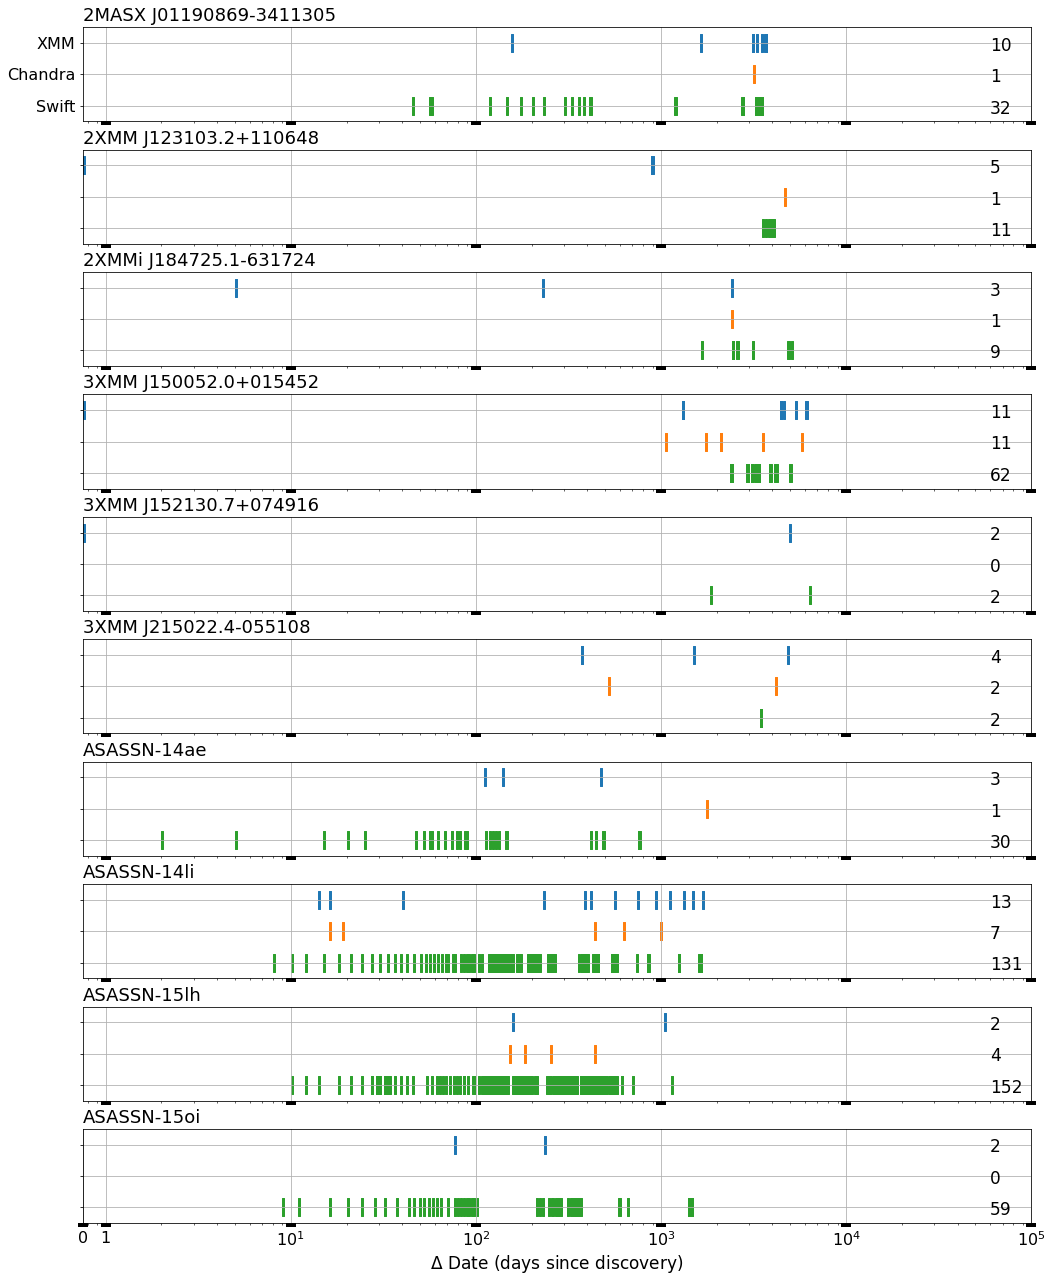

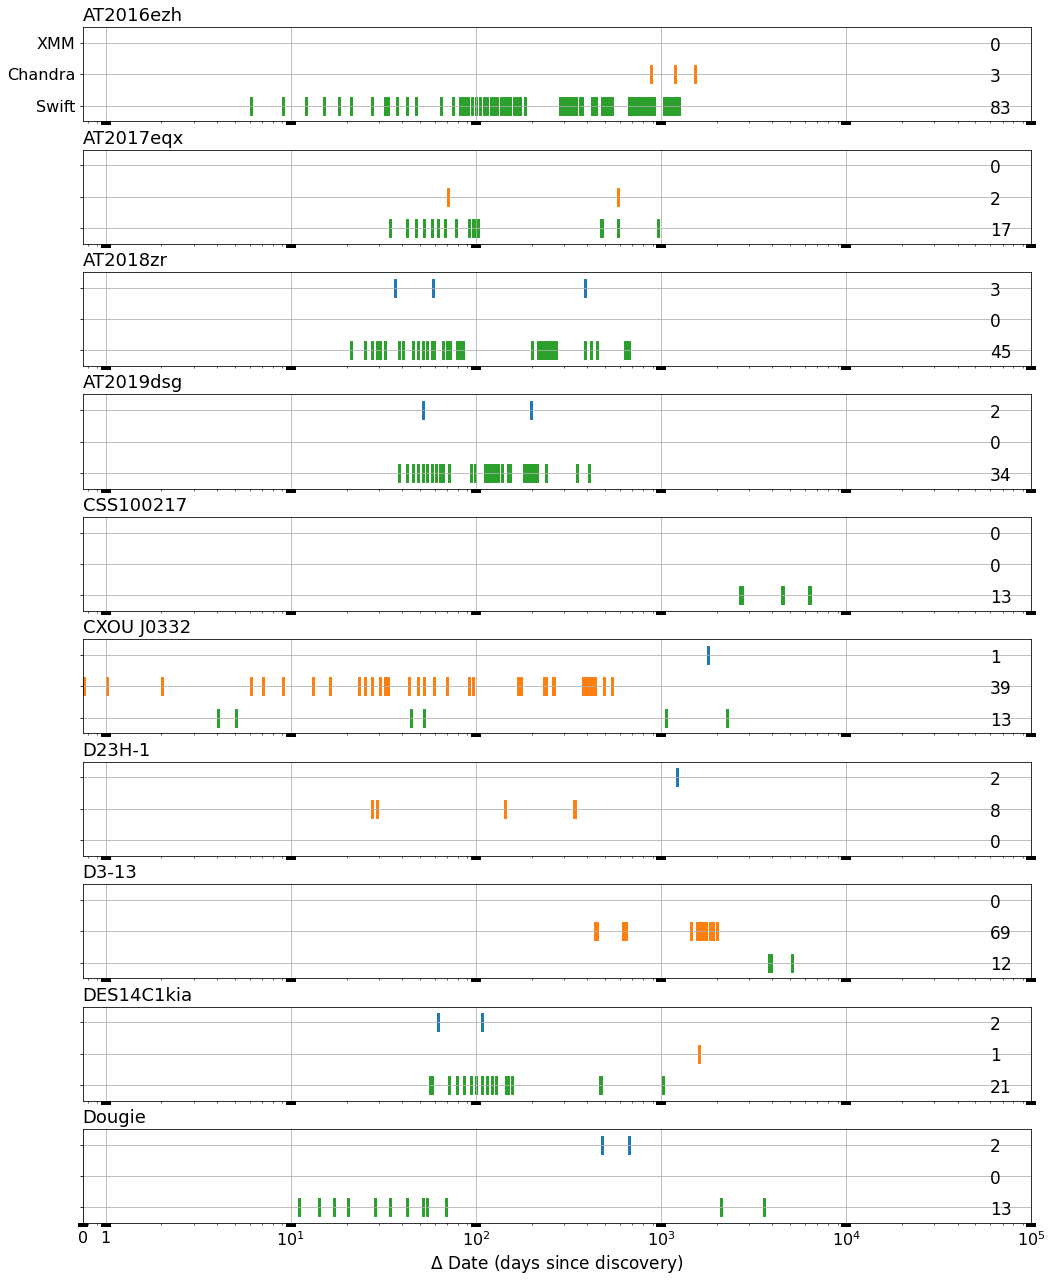

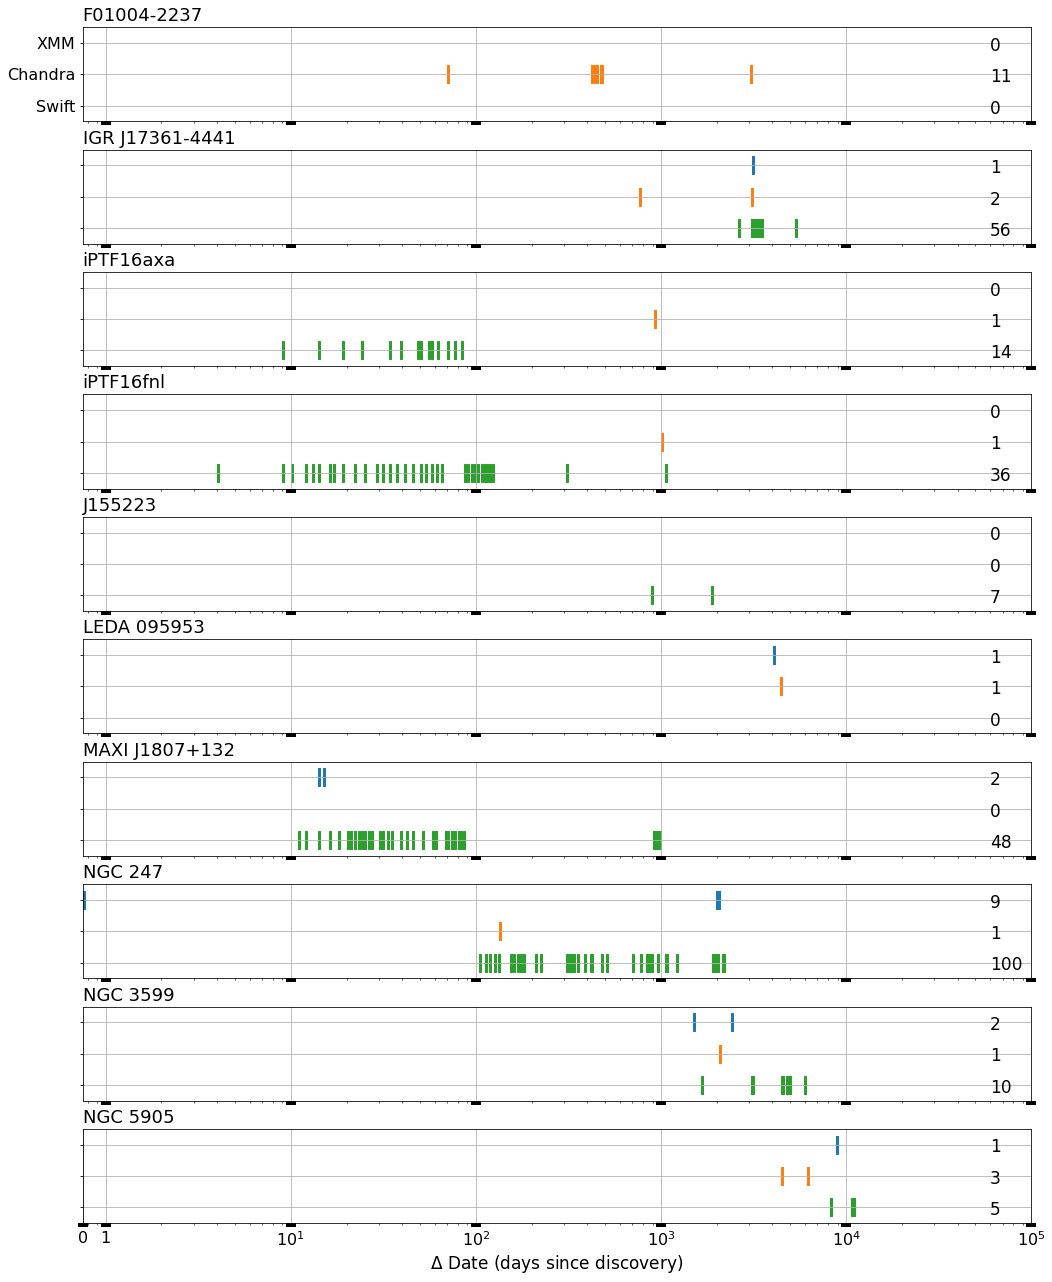

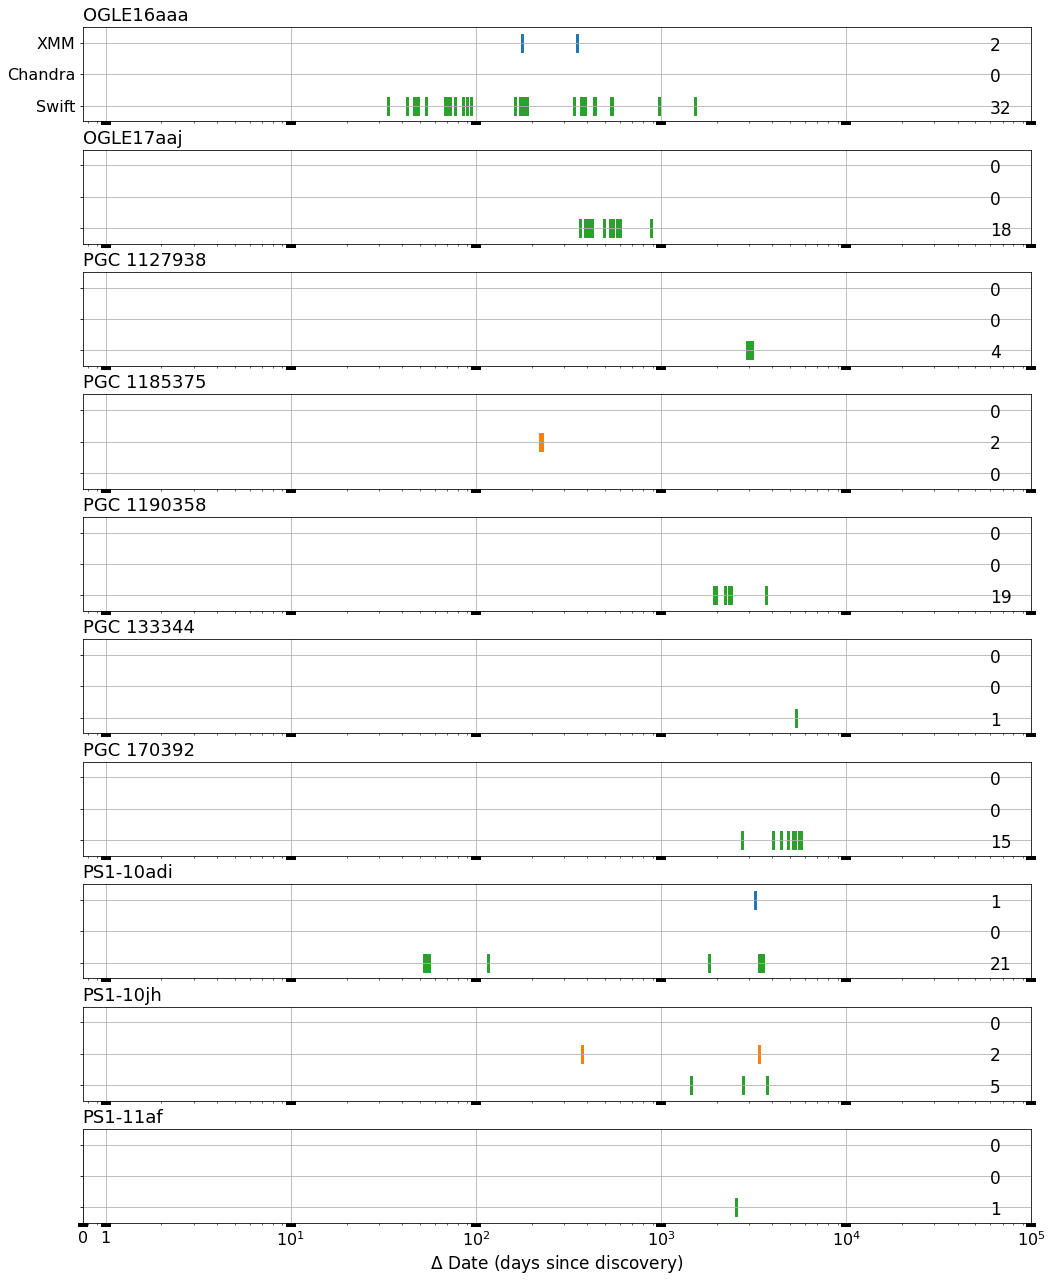

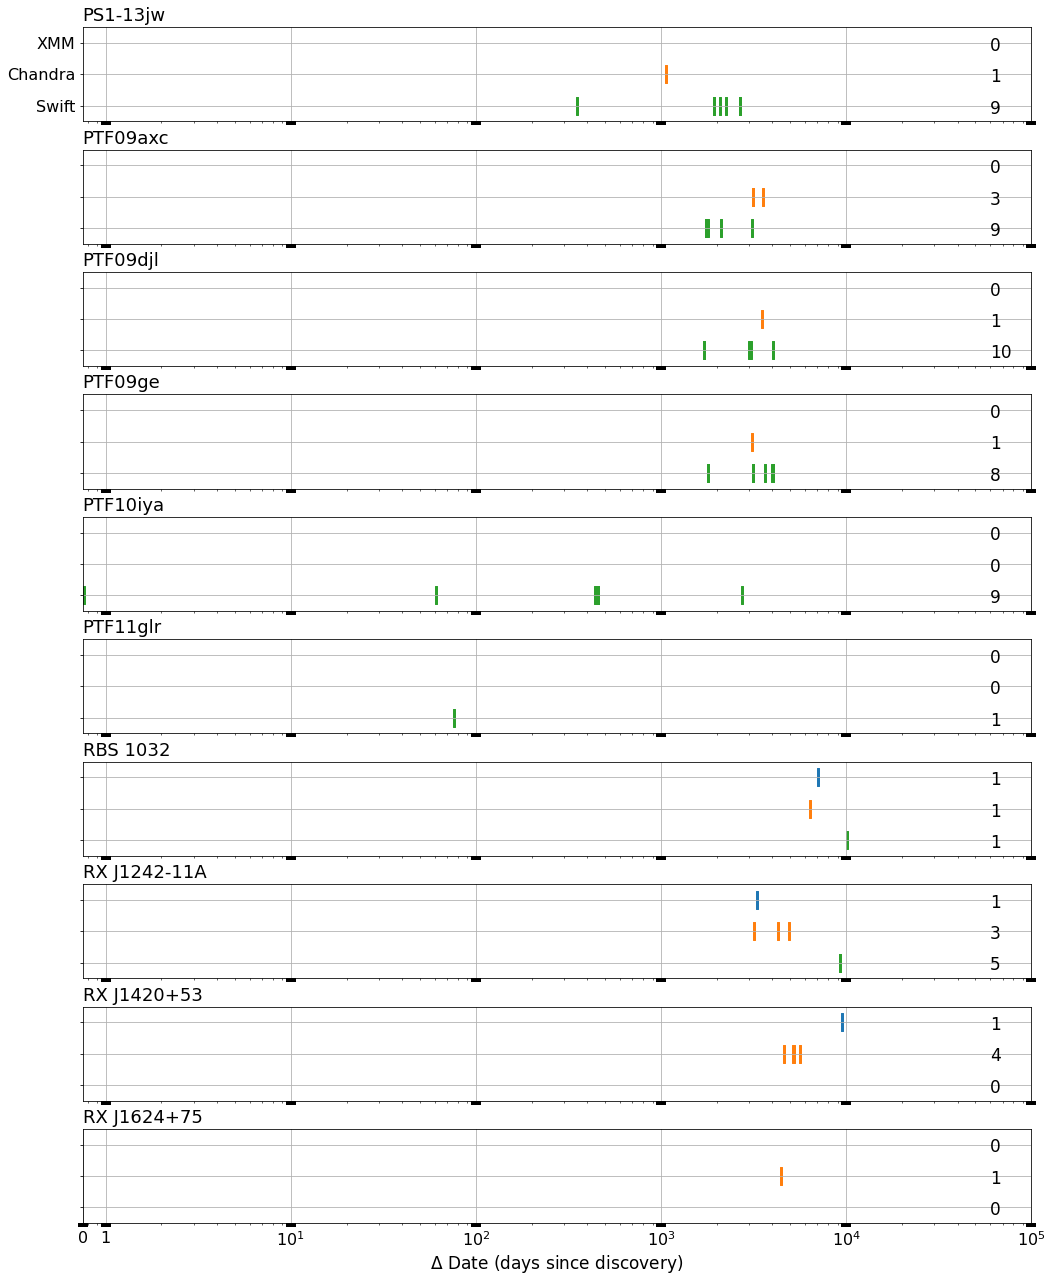

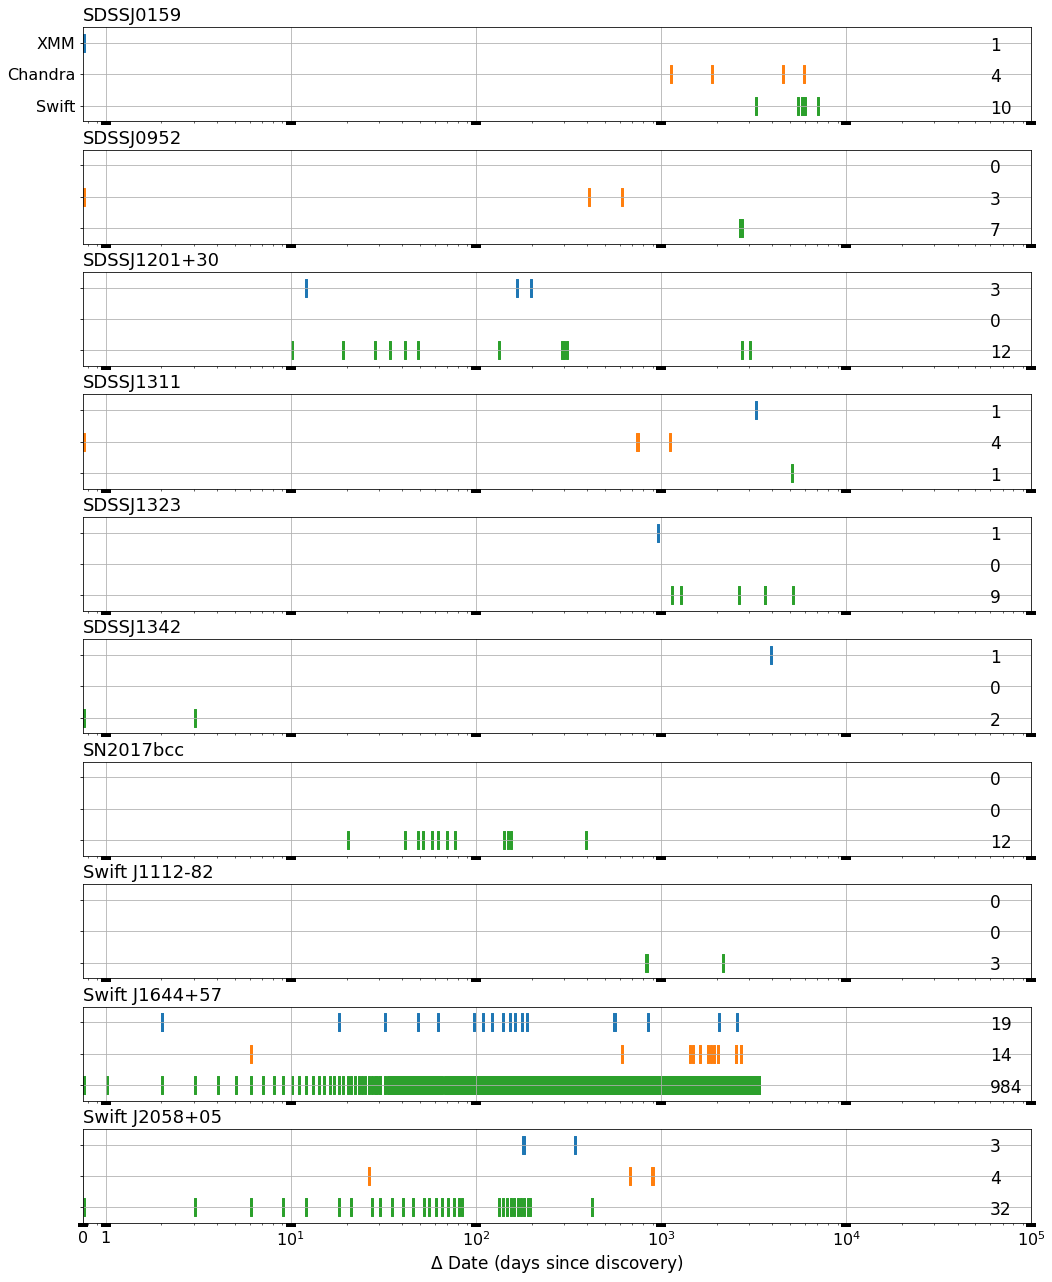

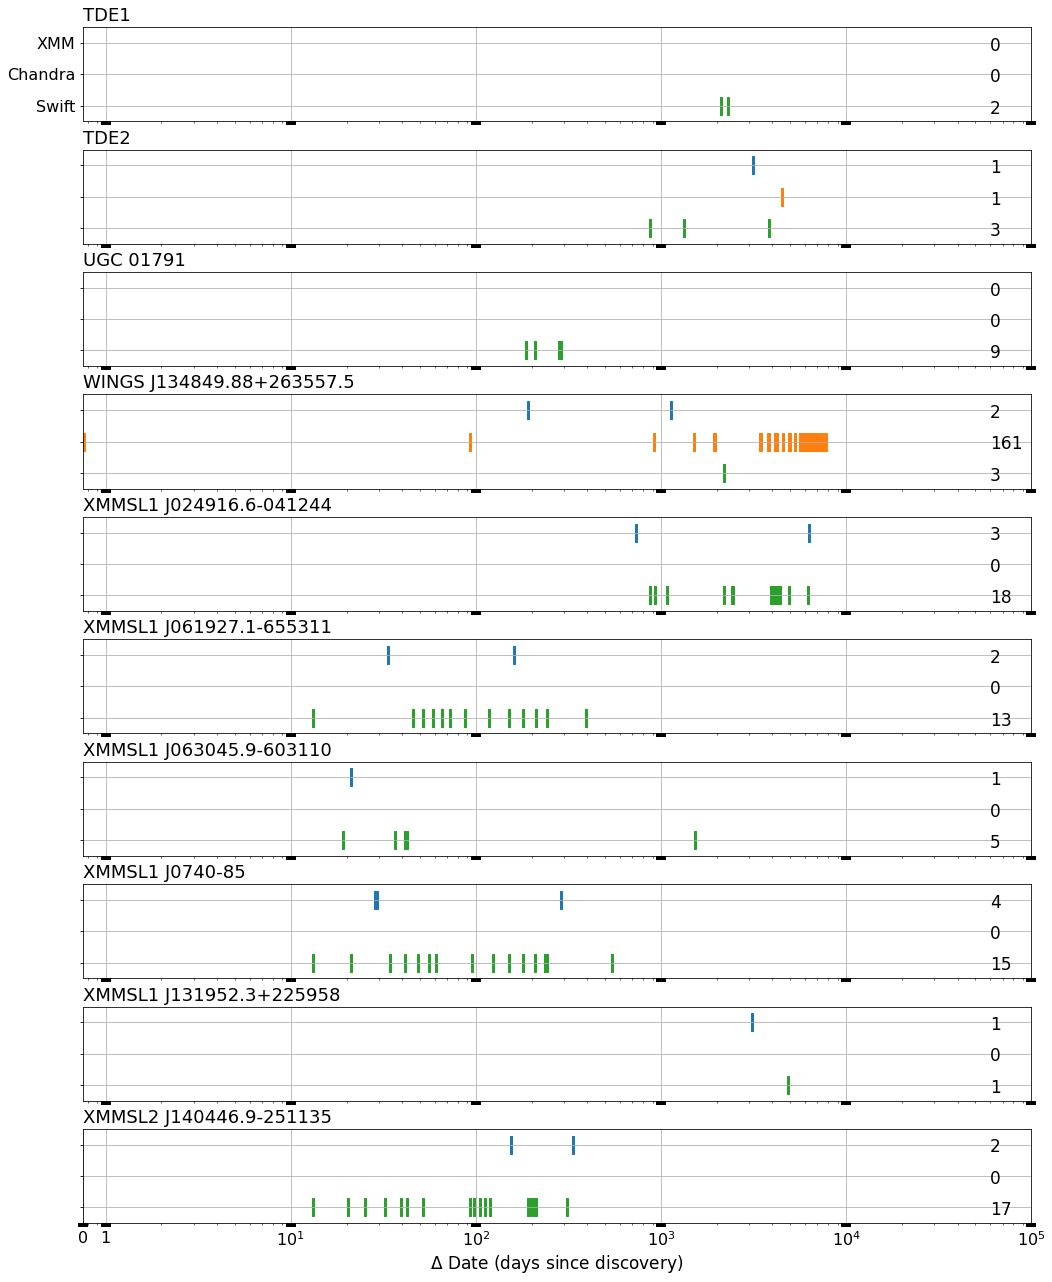

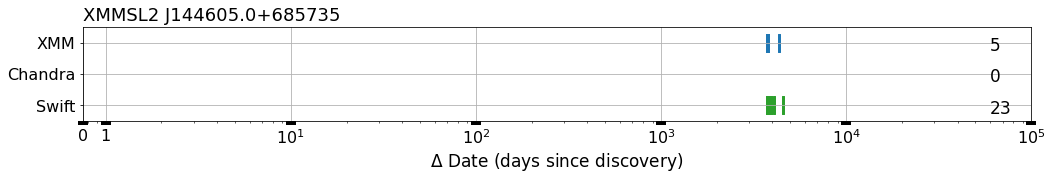

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.backends.backend_pdf import PdfPages

master_set = master_func('TDE Observations', read_folders_in('TDE Observations'))

set_size = len(master_set)

tde_delta_dates_with_i_value_sub_list = []
tde_delta_dates_with_i_value_list = []

"""deleted empty sets"""
deleted_indices.sort(reverse=True)
for index in deleted_indices:
    print(index)
    del master_set[index]
    

# for element in master_set:
#     print(element, '\n')

for tde_set in master_set: 
    tde_delta_dates_with_i_value_sub_list = []
    for sub_set in tde_set:
        tde_name, marker_color, m, n, item_set = sub_set
        file_telescope_source_name, tde_delta_dates = item_set
        tde_delta_dates_with_i_value = [tde_name, marker_color, n, m, tde_delta_dates, file_telescope_source_name]
        tde_delta_dates_with_i_value_sub_list.append(tde_delta_dates_with_i_value)
    tde_delta_dates_with_i_value_list.append(tde_delta_dates_with_i_value_sub_list)
    
    
"""""""""Plotting"""""""""
def make_new_fig(num_subplots_per_page):
    fig, axs = plt.subplots(num_subplots_per_page)
    return fig, axs

'''Initialize Save file (Pdf)'''
if file_save == True:
    pdf_save_file = PdfPages('TDE Timeline Plots.pdf')  # for output
    # pdf_save_file = PdfPages('TDE Timeline PlotsTEST.pdf')  # for testing
    
num_subplots_per_page = 10
# fig, axs = plt.subplots(102-len(deleted_indices))  # Sets number of subplots
# def make_new_fig(num_subplots_per_page)
#     fig, axs = plt.subplots(num_subplots_per_page)

'''''''''Subplotting loop'''''''''
for page_num in range(len(tde_delta_dates_with_i_value_list)//num_subplots_per_page + 1):
    adjustment_amount = num_subplots_per_page * page_num  # used to recalibrate indexing per page
    
    if adjustment_amount+num_subplots_per_page>len(tde_delta_dates_with_i_value_list):
        remainder_amount = len(tde_delta_dates_with_i_value_list)-adjustment_amount  # number of plots on last page
    else:
        remainder_amount = 0  # for a completely filled page

    fig, axs = make_new_fig(num_subplots_per_page)  # makes new plot per page
    for new_index, sets in enumerate(tde_delta_dates_with_i_value_list):
        if new_index < adjustment_amount or new_index > num_subplots_per_page-1+adjustment_amount:
            continue

        '''initialize x_ values'''
        x_xmm = []
        x_chandra = []
        x_swift = []
        
        for items in sets:
            '''use imported variables from read file'''
            tde_name = items[0]
            marker_color = items[1]
            plot_subindex = items[2]
            plot_index = new_index - adjustment_amount
            tde_delta_dates_2 = items[4]
            file_telescope_source_name = items[5]


            '''Define x,y variables to be plotted'''
            x = [int(date) for date in tde_delta_dates_2]
            new_x = []
            
            for dt in x:
                if dt==0:
                    # print("dt=0")
                    dt=0.75
                new_x.append(dt)
            # print(new_x)

            if file_telescope_source_name=="xmm":
                y=[2]*len(tde_delta_dates_2)
                x_xmm = new_x  # save x for legend later
            if file_telescope_source_name=="chandra":
                y=[1]*len(tde_delta_dates_2)
                x_chandra = new_x
            if file_telescope_source_name=="swift":
                y=[0]*len(tde_delta_dates_2)
                x_swift = new_x
        #     y = [plot_subindex]*len(tde_delta_dates_2)
            
            # print(tde_name, file_telescope_source_name, x)

            """Set axes"""
            axs[plot_index].set_xticks([0.75, 1,10,100,1e3,1e4,1e5])
            
            axs[plot_index].set_xscale('log')

            axs[plot_index].set_yticks([0,1,2])
        #     axs[plot_index].set_yticklabels(['Chandra','Swift','XMM'])  # for all plot
            axs[0].set_yticklabels(['Swift','Chandra','XMM'])  # for first plot

            axs[plot_index].set_ylim(-.5,2.5)
            axs[plot_index].set_xlim(0.75, 1e5)

            """Plot settings"""
            scale_factor = 2
            plt.rcParams['figure.figsize'] = (8.5*scale_factor,11*scale_factor)
            plt.rcParams['xtick.major.width'] = 10
            plt.rcParams['xtick.labelsize'] = 16  # x-axis tick label font size
            plt.rcParams['ytick.labelsize'] = 16  # y axis tick label font size
            plt.rcParams.update({'font.size':15})  # subplot title font size
            axs[plot_index].grid(True)
            
            plt.xticks([0.75, 1,10,100,1e3,1e4,1e5]
                       , [r"$0$",r"$1$" ,r"$10^1$", r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$"]
                      )
        #     plt.grid(True)
        #     if plot_subindex == 0:
        #         axs[plot_index].grid()

            """Add Subplot Titles"""
        #     axs[0].set_title('Timeline')
            axs[plot_index].set_title(f'{tde_name}',loc='left')

            """add axes titles"""
            '''x axis title'''
            if remainder_amount==0:
                axs[-1].set_xlabel('$\Delta$ Date (days since discovery)'
                                                    , fontsize=17)  # labels only last plot
            else:
                axs[remainder_amount-1].set_xlabel('$\Delta$ Date (days since discovery)'
                                                    , fontsize=17)  # labels only last plot
                
        #     axs[plot_index].set_xlabel('$\Delta$ Date (days since discovery)')  # labels all plots
            '''y axis title'''
        #     axs[plot_index].set_ylabel(f'{tde_name}',rotation=0)

            """remove axes titles"""
            '''x axis removal'''
            # axs[plot_index].axes.get_xaxis().set_visible(False) # removes x-labels for all
            if remainder_amount == 0:
                if plot_index < num_subplots_per_page-1: # removes x-labels for all but last row
        #             axs[plot_index].axes.get_xaxis().set_visible(False)
                    axs[plot_index].set_xticklabels([])
            else:
                if plot_index < remainder_amount-1:
                    axs[plot_index].set_xticklabels([])
                if plot_index == remainder_amount-1:
                    plt.sca(axs[plot_index])
                    plt.xticks([0.75, 1,10,100,1e3,1e4,1e5]
                       , [r"$0$",r"$1$" ,r"$10^1$", r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$"]
                      )
            '''y axis removal'''
        #     axs[plot_index].axes.get_yaxis().set_visible(False) # removes y-labels for all
            if plot_index > 0:  # removes y-labels for all but first rows
    #             axs[plot_index].axes.get_yaxis().set_visible(False) 
                axs[plot_index].set_yticklabels([])

            """add subplot labels inside plot area"""
        #     fig.text(0, 0.01*plot_index, s=f"{tde_name}", fontsize=15)
            
            
            """plotting"""
        #     axs[plot_index].plot(new_x,y,f'{marker_color}|', markersize=20)  # for simple markers
        #     axs[plot_index].plot(new_x,y, color=f'{marker_color}', marker='$|$', markersize=10) # for string markers
            axs[plot_index].scatter(new_x,y, s=300, color=f'{marker_color}', marker='$|$') # Scatter Plot version, s=size of markers
    
            """""""""Post-Plotting (after each x) Adjustments"""""""""
            '''Main Title'''
            # fig.suptitle('TDE Timelines', fontsize=25, y = 0.91)

            '''Spacing'''
            fig.subplots_adjust(hspace=.3)  # (original = 0.7) adjusts spacing between plots. hspace in fraction of total subplot height.
            # fig.tight_layout()  # too restictive
            plt.grid(True)
        
        """""""""Post-subplot (after 3 loops) Adjustments"""""""""
        
        '''add label for number of x ticks in each row'''
        count_fontsize = 17
#         axs[plot_index].legend((f'{len(x_xmm)}',f'{len(x_chandra)}',f'{len(x_swift)}'), loc='upper right')  # not working as intended
        axs[plot_index].text(60000, 2-.25, f'{len(x_xmm)}', fontsize=count_fontsize)
        axs[plot_index].text(60000, 1-.25, f'{len(x_chandra)}', fontsize=count_fontsize)
        axs[plot_index].text(60000, 0-.25, f'{len(x_swift)}', fontsize=count_fontsize)
        
#         axs[plot_index].text(90, 2, f'{len(x_xmm)}', fontsize=count_fontsize)
#         axs[plot_index].text(90, 1, f'{len(x_chandra)}', fontsize=count_fontsize)
#         axs[plot_index].text(90, 0, f'{len(x_swift)}', fontsize=count_fontsize)
        
    """Get rid of empty plots at end"""
    for i in range(num_subplots_per_page):
        if axs[i].get_title(loc='left')=="": 
            print(f"setting {i}th row invisible")
            axs[i].set_visible(False)

            
    """Save plot page as a page of a master pdf"""
    if file_save == True:
        pdf_save_file.savefig(fig, pad_inches=1.0)
#                                     dpi=None, 
#                                     facecolor='w', 
#                                     edgecolor='w',
#                                     orientation='portrait', 
#                                     papertype=None, 
#                                     format=pdf,
#                                     transparent=False, 
#                                     bbox_inches=None, 
#                                     pad_inches=1.0,
#                                     frameon=None, 
#                                     metadata=None)

if file_save == True:
    pdf_save_file.close()


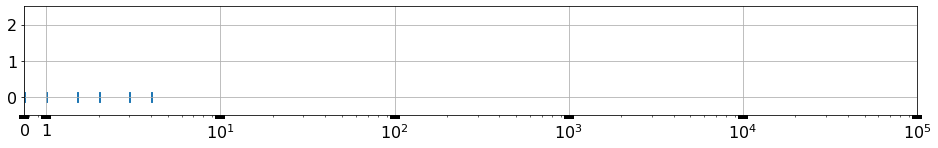

In [27]:
plt.figure(figsize=(16, 1.5))

x = [0,1,2,3,4,1.5,0.75]
y = [0,0,0,0,0,0,0]
plt.scatter(x,y, marker='$|$', s = 100)

plt.xscale('log')

plt.xlim(1,1e5)

plt.xticks([0.75, 1,10,100,1e3,1e4,1e5]
           , [r"$0$",r"$1$" ,r"$10^1$", r"$10^2$", r"$10^3$", r"$10^4$", r"$10^5$"]
          )

plt.yticks([0, 1, 2])

plt.ylim(-0.5, 2.5)

plt.grid(True)

plt.show()